In [2]:
import pandas as pd
import FinanceDataReader as fdr
import numpy as np
import talib as ta

In [3]:
# 종목 OHLCV 데이터 로드
df = fdr.DataReader('QQQ', start='2020-01-01')
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-29,262.959991,267.399994,262.250000,266.440002,266.440002,45893600
2022-12-30,263.619995,266.410004,262.290009,266.279999,266.279999,37796100
2023-01-03,268.649994,270.149994,262.130005,264.480011,264.480011,42335300
2023-01-04,266.640015,267.450012,262.529999,265.739990,265.739990,47754900
2023-01-05,264.040009,264.209991,261.260010,261.579987,261.579987,45396700
2023-01-06,263.350006,269.940002,260.339996,268.799988,268.799988,54573600
2023-01-09,270.829987,275.290009,269.920013,270.540009,270.540009,45568700
2023-01-10,269.489990,272.940002,268.970001,272.829987,272.829987,35247800
2023-01-11,273.920013,277.660004,273.119995,277.549988,277.549988,44077000


<AxesSubplot:xlabel='Date'>

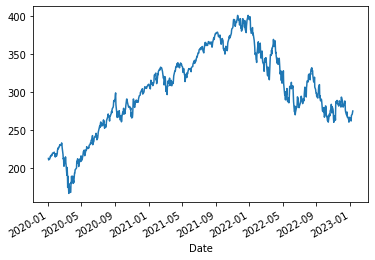

In [4]:
df = pd.read_csv("./data/QQQ_20200101-.csv", index_col="Date", parse_dates=["Date"])
df["Adj Close"].plot()

In [5]:
df.to_csv("./data/QQQ_20200101-.csv")

In [6]:
df_price = df.loc[:, ["Adj Close"]]
df_price.columns = ["Close"]
df_price.head()

,Close
Date,
2020-01-02,212.340881
2020-01-03,210.395874
2020-01-06,211.751495
2020-01-07,211.722046
2020-01-08,213.313431


In [7]:
# 볼린져 밴드의 중앙값, 상단, 하단 값 구하기(talib 이용)
df_price["center"], df_price["ub"], df_price["lb"] = ta.BBANDS(df_price.Close, 20, 2)

In [8]:
df_price[10:30]

,Close,center,ub,lb
Date,,,,
2020-01-16,218.352798,NaN,NaN,NaN
2020-01-17,219.433380,NaN,NaN,NaN
2020-01-21,219.335098,NaN,NaN,NaN
2020-01-22,219.914703,NaN,NaN,NaN
2020-01-23,220.621979,NaN,NaN,NaN
2020-01-24,218.765350,NaN,NaN,NaN
2020-01-27,214.246658,NaN,NaN,NaN
2020-01-28,217.537430,NaN,NaN,NaN
2020-01-29,217.891083,NaN,NaN,NaN


In [9]:
# 중앙값 20일 MA로 발생한 결측치 행 제거(쿠션 행)
df_bollinger = df_price.dropna(axis=0)
df_bollinger.head()

,Close,center,ub,lb
Date,,,,
2020-01-30,218.667145,222.186373,216.174950,210.163528
2020-01-31,215.199509,222.088996,216.317882,210.546767
2020-02-03,218.451019,221.873592,216.720639,211.567686
2020-02-04,223.451080,222.719066,217.305618,211.892171
2020-02-05,224.187836,223.495701,217.928908,212.362115


In [10]:
# 거래 기준일 
base_date = "2020-5-20"
# 거래에 활용할 샘플 데이터
df_sample = df_bollinger.loc[base_date:]
df_sample.head()

,Close,center,ub,lb
Date,,,,
2020-05-20,227.786194,227.603003,216.560808,205.518613
2020-05-21,225.305466,228.261699,217.464018,206.666337
2020-05-22,226.083145,229.167416,218.242699,207.317981
2020-05-26,225.472809,229.894706,218.906201,207.917696
2020-05-27,226.703369,230.155116,219.831071,209.507025


In [11]:
# 거래 내역 기록용 데이터 프레임
df_book = df_sample.loc[:, ["Close"]].copy()
df_book["trade"] = ""

In [19]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, "Close"] > sample.loc[i, "ub"]: # 상단 돌파
            book.loc[i, 'trade'] = "" # Release 상태 전환
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Close']: # 하단 돌파
            if book.shift(1).loc[i, 'trade'] == 'buy': # 기존 상태가 홀드라면               
                book.loc[i, 'trade'] = 'buy' # 홀드 유지
            else:
                book.loc[i, 'trade'] = 'buy' # 기존 상태가 Release 라면 홀드로 전환
        elif sample.loc[i, 'ub'] >= sample.loc[i, "Close"] and sample.loc[i, "Close"] >= sample.loc[i, 'lb']: # 가격이 밴드 범위안에 있다면
            if book.shift(1).loc[i, 'trade'] == 'buy': # 기존 상태가 홀드 라면
                book.loc[i, 'trade'] = 'buy' # 홀드 유지
            else:
                book.loc[i, 'trade'] = '' # 기존 상태가 Release라면 기존 상태 유지
    return book

In [15]:
df_book = tradings(df_sample, df_book)
df_book[df_book['trade'] == 'buy']

,Close,trade
Date,,
2020-10-28,267.874390,buy
2020-10-29,272.558533,buy
2020-10-30,265.645752,buy
2020-11-02,266.237427,buy
2020-11-03,270.842621,buy
...,...,...
2023-01-03,264.480011,buy
2023-01-04,265.739990,buy
2023-01-05,261.579987,buy


In [16]:
df_book["rtn"] = df_book.Close.pct_change()+1
df_book.rtn.iat[0] = 1
df_book.head()    

,Close,trade,rtn
Date,,,
2020-05-20,227.786194,,1.000000
2020-05-21,225.305466,,0.989109
2020-05-22,226.083145,,1.003452
2020-05-26,225.472809,,0.997300
2020-05-27,226.703369,,1.005458


In [17]:
# 포지션이 buy(보유)일 경우에만 시세 변동을 반영하도록 함.
df_book['trade_rtn'] = np.where(df_book['trade'].shift(1) == 'buy', df_book.rtn, 1)
df_book.head()

,Close,trade,rtn,trade_rtn
Date,,,,
2020-05-20,227.786194,,1.000000,1.0
2020-05-21,225.305466,,0.989109,1.0
2020-05-22,226.083145,,1.003452,1.0
2020-05-26,225.472809,,0.997300,1.0
2020-05-27,226.703369,,1.005458,1.0


In [22]:
# 보유일 경우 시세 변동을 누적 곱하여 최종 수익률을 계산
df_book['sys_rtn'] = df_book.trade_rtn.cumprod()
df_book.tail(30)

,Close,trade,rtn,trade_rtn,sys_rtn
Date,,,,,
2022-11-29,279.899902,,0.992430,1.000000,1.076326
2022-11-30,292.659332,,1.045586,1.000000,1.076326
2022-12-01,293.018494,,1.001227,1.000000,1.076326
2022-12-02,291.851288,,0.996017,1.000000,1.076326
2022-12-05,286.953033,,0.983217,1.000000,1.076326
2022-12-06,281.007233,,0.979280,1.000000,1.076326
2022-12-07,279.859985,,0.995917,1.000000,1.076326
2022-12-08,283.172058,,1.011835,1.000000,1.076326
2022-12-09,281.366394,,0.993623,1.000000,1.076326


<AxesSubplot:xlabel='Date'>

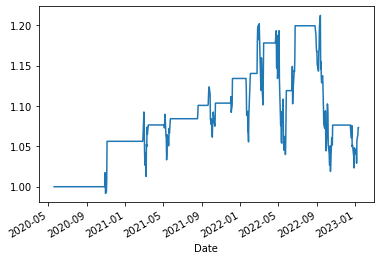

In [19]:
df_book.sys_rtn.plot()

<AxesSubplot:xlabel='Date'>

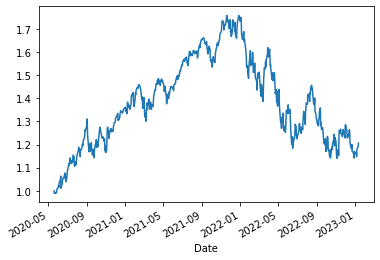

In [20]:
df_book.rtn.cumprod().plot()